In [1]:
import os
import pandas as pd
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import emoji
from scipy.stats import gaussian_kde # Create smooth KDE plot

In [2]:
timestamp_re = r"(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)"
user_re = r"(?P<user>[^:]+)"
content_re = r"(?P<content>.+)"
value_re = r"(?P<value>[-+]?\d\.?\d?\d?)"
message_re = f"{timestamp_re} ?\|? ?{user_re}:\n?\s?{content_re}\n?\s?Polarity: {value_re}"
MSGS_REGEX = re.compile(message_re)

MODEL_CHECKPOINT = 'dbmdz/bert-base-italian-cased'
TASK = 'binary'

if TASK == 'multiclass':
    TARGET_NAMES = ['Toxic', 'Neutral', 'Healthy']
    THRESHOLDS = (-1.01, -0.35, 0.35, 1.01)
    LABELS = [0, 1, 2]
else:
    TARGET_NAMES = ['Toxic', 'Healthy']
    THRESHOLDS = (-1.01, -0.35, 1.01)
    LABELS = [0, 1]

DATASET_TYPE = 'toxicity'
PATH = os.path.join(".", "out", "datasets", f"cipv-chats-{DATASET_TYPE}", "chats")

# Loading

In [3]:
def load_dataset(path):
    dataset = {
        # 'chat_ids': [],
        'couple_ids': [],
        'messages': []
        # 'msg_timestamps': [],
        # 'msg_users': [],
        # 'msg_contents': [],
        # 'msg_values': [],
    }
    skipped = 0
    chat_id = 0
    model_dirs = os.listdir(path)
    for model_dir in tqdm(model_dirs, desc="📂 Loading Dataset"):
        model_dir_path = os.path.join(path, model_dir)
        couple_dirs = os.listdir(model_dir_path)
        for couple_dir in tqdm(couple_dirs, desc=f"📂 Loading Directory: {model_dir_path}", leave=False):
            couple_dir_path = os.path.join(model_dir_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                file_path = os.path.join(couple_dir_path, file)
                with open(file_path, "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(MSGS_REGEX.finditer(chat))
                    if len(messages) > 0: # checks if there are matched messages
                        # dataset['chat_ids'].append(chat_id) # += [chat_id] * len(messages)
                        dataset['couple_ids'].append(couple_dir) # += [couple_dir] * len(messages)
                        # dataset['msg_timestamps'] += [msg.group("timestamp") for msg in messages]
                        # dataset['msg_contents'] += [msg.group("content") for msg in messages]
                        # dataset['msg_users'] += [msg.group("user") for msg in messages]
                        # dataset['msg_values'] += [float(msg.group("value")) for msg in messages]
                        dataset['messages'].append([
                            {
                                "timestamp": msg.group("timestamp"),
                                "content": msg.group("content"),
                                "user": msg.group("user"),
                                "value": float(msg.group("value"))
                            }
                            for msg in messages
                        ])
                        chat_id += 1
                    else:
                        skipped += 1
                        print(f"No messages found in file: {os.path.join(couple_dir_path, file)}")

    df = pd.DataFrame(dataset)
    return df, skipped

In [4]:
df, skipped = load_dataset(PATH)
print(df.info())
print(f"\nSkipped files: {skipped}")

📂 Loading Dataset:   0%|          | 0/6 [00:00<?, ?it/s]

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.0-flash-dataset_2025-07-09-15-56-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-07-10-45-16:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-08-20-06-22:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-16-09-07-33:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-dataset_2025-07-19-14-42-59:   …

📂 Loading Directory: .\out\datasets\cipv-chats-toxicity\chats\gemini-2.5-flash-lite-preview-06-17-dataset_2025…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   couple_ids  2079 non-null   object
 1   messages    2079 non-null   object
dtypes: object(2)
memory usage: 32.6+ KB
None

Skipped files: 0


# Tokenizing

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize(messages):
    chat = '[CLS]' + ("[SEP]" + "\n").join([f"{msg['user']}:\n{msg['content']}" for msg in messages])
    chat = emoji.demojize(chat, language='it')
    inputs = tokenizer(chat, add_special_tokens=False)['input_ids']

    return len(inputs)# + len(messages)

df['chat_token_lengths'] = df['messages'].apply(
    lambda messages: tokenize(messages)
)

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


In [6]:
def plot_token_length_distribution(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Calculate statistics for display
    token_lengths = df['chat_token_lengths']
    mean_length = token_lengths.mean()
    median_length = token_lengths.median()
    max_length = token_lengths.max()
    
    # Calculate samples over 512 tokens
    over_512 = (token_lengths > 512).sum()
    total_samples = len(token_lengths)
    percent_over_512 = (over_512 / total_samples) * 100
    
    counts, bins, patches = ax.hist(
        token_lengths, 
        bins=max_length,  # Cap bins to avoid too many
        color='#3498db',
        alpha=0.7,
        edgecolor="#375f7a",
        linewidth=1
    )
    
    # Color bars differently for over 512 tokens
    for i, (patch, bin_start) in enumerate(zip(patches, bins[:-1])):
        if bin_start > 512:
            patch.set_color('#e74c3c')  # Red for over 512
            patch.set_alpha(0.8)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_length:.1f}')
    ax.axvline(median_length, color='orange', linestyle='--', linewidth=2, 
               label=f'Median: {median_length:.1f}')
    
    # Add 512 token limit line (BERT limit)
    ax.axvline(512, color='green', linestyle=':', linewidth=3, 
               label=f'BERT Limit (512)')
    
    # Customize plot
    ax.set_xlabel('Chat Token Length', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Chat Token Lengths', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(False)
    
    # Add statistics text box with 512+ info
    stats_text = f'Total Chats: {total_samples:,}\n'
    stats_text += f'Max Length: {max_length:,}\n'
    stats_text += f'Std Dev: {token_lengths.std():.1f}\n'
    stats_text += f'Over 512 tokens: {over_512:,} ({percent_over_512:.1f}%)'
    
    ax.text(0.75, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print additional info
    print(f"Samples over 512 tokens: {over_512:,} out of {total_samples:,} ({percent_over_512:.2f}%)")
    print(f"Samples under/equal 512 tokens: {total_samples - over_512:,} ({100 - percent_over_512:.2f}%)")

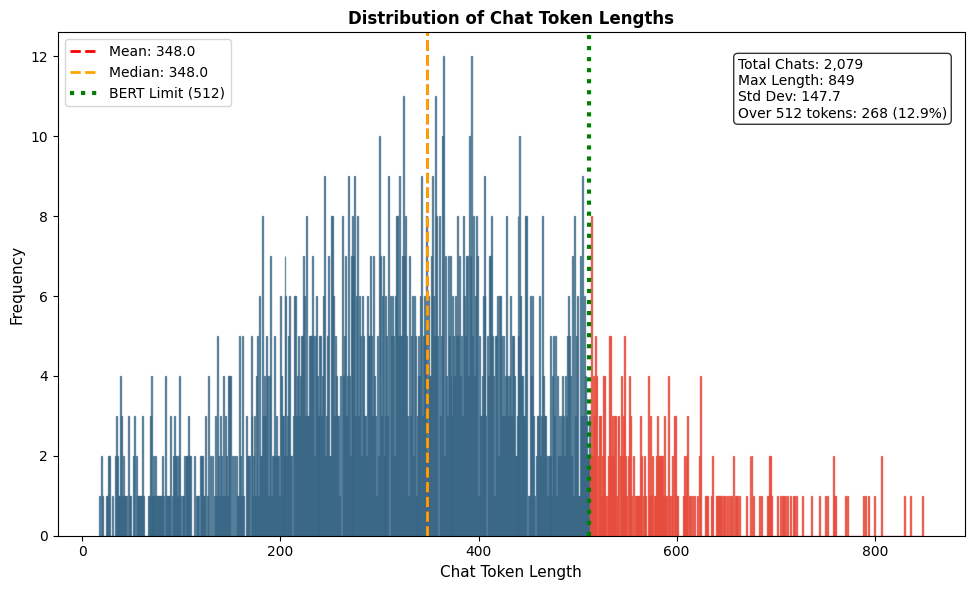

Samples over 512 tokens: 268 out of 2,079 (12.89%)
Samples under/equal 512 tokens: 1,811 (87.11%)


In [7]:
plot_token_length_distribution(df)

# Labelling

In [8]:
# create labels
def clf(messages):
    df = pd.DataFrame(messages)
    return df.groupby('user').agg({'value': 'mean'})['value'].min()

df['min_avg_value'] = df['messages'].apply(clf)
df['labels'] = pd.cut(
    df['min_avg_value'], 
    bins=THRESHOLDS, 
    labels=LABELS
)
# remove all rows that have at least a NaN value
# df = df.dropna()
df['labels'] = df['labels'].astype(int)

In [9]:
# filter and count NaN values
nan_mask = df.isna().any(axis=1)
print(df[nan_mask])

Empty DataFrame
Columns: [couple_ids, messages, chat_token_lengths, min_avg_value, labels]
Index: []


# Filtering

In [10]:
def check_chat(row):
    users = set(msg['user'] for msg in row['messages'])
    if row['chat_token_lengths'] <= 512 and len(users) in [1, 2]:
        return True
    return False

mask = df.apply(
    lambda row: check_chat(row),
    axis=1
)
filtered = df[~mask]
print(f"Filtered: {len(filtered)}")
# count label distribution in filtered
print(filtered['labels'].value_counts())
df = df[mask]

Filtered: 270
labels
0    139
1    131
Name: count, dtype: int64


# Analysis

In [11]:
def plot_value_distribution(df: pd.DataFrame) -> None:
    COLORS = {'toxic': '#e74c3c', 'neutral': '#f39c12', 'healthy': '#27ae60'}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Histogram of min average values
    
    # Add colored background regions first (so they appear behind the histogram)
    if len(TARGET_NAMES) == 3:  # multiclass case
        ax1.axvspan(THRESHOLDS[0], THRESHOLDS[1], alpha=0.15, color=COLORS['toxic'], label='Toxic Region')
        ax1.axvspan(THRESHOLDS[1], THRESHOLDS[2], alpha=0.15, color=COLORS['neutral'], label='Neutral Region')
        ax1.axvspan(THRESHOLDS[2], THRESHOLDS[3], alpha=0.15, color=COLORS['healthy'], label='Healthy Region')
        
        # Add threshold lines
        ax1.axvline(
            x=THRESHOLDS[1], 
            color=COLORS['toxic'], 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Toxic Threshold ({THRESHOLDS[1]})'
        )
        ax1.axvline(
            x=THRESHOLDS[2], 
            color=COLORS['healthy'], 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Healthy Threshold ({THRESHOLDS[2]})'
        )
    else:  # binary case
        ax1.axvspan(THRESHOLDS[0], THRESHOLDS[1], alpha=0.15, color=COLORS['toxic'], label='Toxic Region')
        ax1.axvspan(THRESHOLDS[1], THRESHOLDS[2], alpha=0.15, color=COLORS['healthy'], label='Healthy Region')
        
        # Add threshold line
        ax1.axvline(
            x=THRESHOLDS[1], 
            color='gray', 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Threshold ({THRESHOLDS[1]})'
        )
    
    ax1.hist(
        df["min_avg_value"], 
        bins=np.linspace(-1, 1, 100), 
        edgecolor='black', 
        alpha=0.8, 
        color='#3498db',
        density=False
    )
    
    ax1.set_xlabel('Min Average Value', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Distribution of Min Average Values', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(False)
    ax1.set_xlim(-1, 1)
    
    # Right plot: Bar chart of label counts
    label_counts = df["labels"].value_counts().sort_index()
    bar_colors = [COLORS['toxic'], COLORS['neutral'], COLORS['healthy']][:len(label_counts)]
    
    bars = ax2.bar(
        range(len(label_counts)), 
        label_counts.values, 
        color=bar_colors, 
        alpha=0.8, 
        edgecolor='black',
        linewidth=1
    )
    
    # Customize x-axis
    ax2.set_xticks(range(len(label_counts)))
    ax2.set_xticklabels(TARGET_NAMES[:len(label_counts)], fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('Distribution of Labels', fontsize=12, fontweight='bold')
    ax2.grid(False)
    
    # Add count labels on bars
    for bar, count in zip(bars, label_counts.values):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2, 
            height + max(label_counts.values) * 0.01,
            f'{count:,}', 
            ha='center', 
            va='bottom', 
            fontweight='bold',
            fontsize=10
        )
    
    # Add percentage labels
    total_count = label_counts.sum()
    for bar, count in zip(bars, label_counts.values):
        percentage = (count / total_count) * 100
        ax2.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() / 2,
            f'{percentage:.1f}%', 
            ha='center', 
            va='center', 
            fontweight='bold',
            fontsize=9,
            color='white'
        )
    
    plt.tight_layout()
    plt.show()

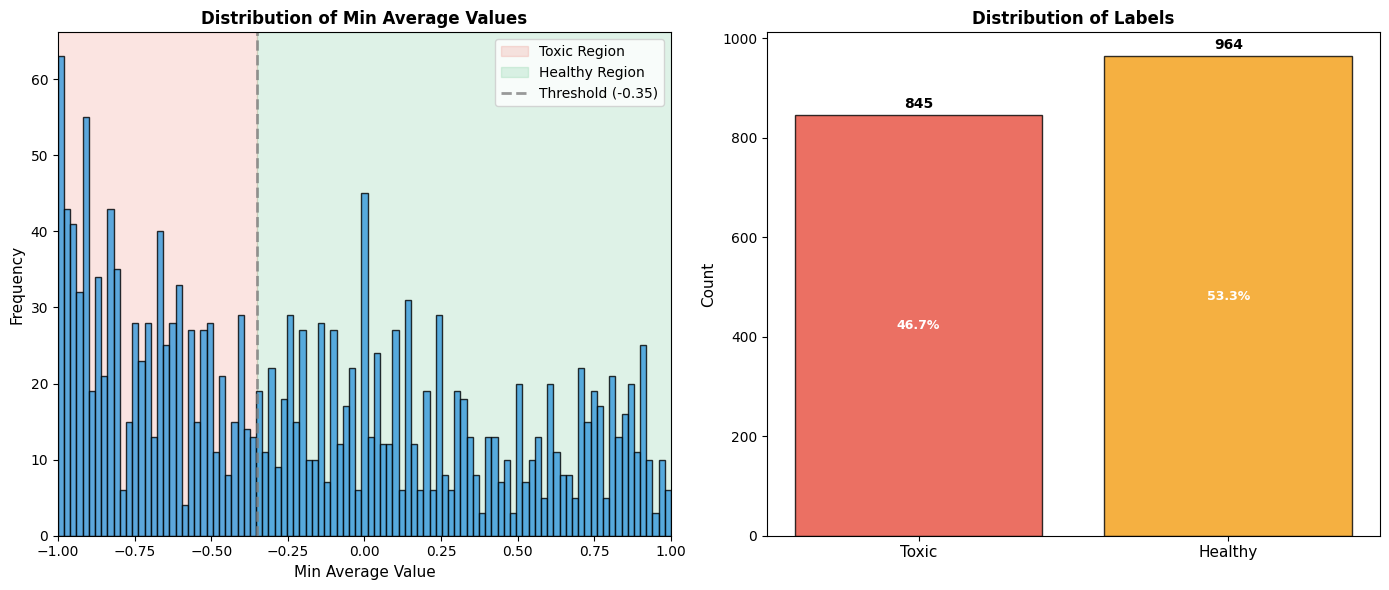

In [12]:
plot_value_distribution(df)

In [13]:
def plot_value_distribution(df: pd.DataFrame) -> None:
    COLORS = {'toxic': '#e74c3c', 'neutral': '#f39c12', 'healthy': '#27ae60'}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: KDE plot (smooth density curve)
    
    # Add colored background regions first
    if len(TARGET_NAMES) == 3:  # multiclass case
        ax1.axvspan(THRESHOLDS[0], THRESHOLDS[1], alpha=0.15, color=COLORS['toxic'], label='Toxic Region')
        ax1.axvspan(THRESHOLDS[1], THRESHOLDS[2], alpha=0.15, color=COLORS['neutral'], label='Neutral Region')
        ax1.axvspan(THRESHOLDS[2], THRESHOLDS[3], alpha=0.15, color=COLORS['healthy'], label='Healthy Region')
    else:  # binary case
        ax1.axvspan(THRESHOLDS[0], THRESHOLDS[1], alpha=0.15, color=COLORS['toxic'], label='Toxic Region')
        ax1.axvspan(THRESHOLDS[1], THRESHOLDS[2], alpha=0.15, color=COLORS['healthy'], label='Healthy Region')
    
    # Create density estimation
    kde = gaussian_kde(df["min_avg_value"])
    x_range = np.linspace(-1, 1, 200)  # High resolution for smoothness
    density = kde(x_range)
    
    # Plot the smooth curve
    ax1.fill_between(x_range, density, alpha=0.7, color='#3498db', edgecolor='black', linewidth=1)
    ax1.plot(x_range, density, color='#2980b9', linewidth=2)
    
    # Add threshold lines
    if len(TARGET_NAMES) == 3:  # multiclass case
        ax1.axvline(
            x=THRESHOLDS[1], 
            color=COLORS['toxic'], 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Toxic Threshold ({THRESHOLDS[1]})'
        )
        ax1.axvline(
            x=THRESHOLDS[2], 
            color=COLORS['healthy'], 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Healthy Threshold ({THRESHOLDS[2]})'
        )
    else:  # binary case
        ax1.axvline(
            x=THRESHOLDS[1], 
            color='gray', 
            linestyle='--', 
            alpha=0.8, 
            linewidth=2,
            label=f'Threshold ({THRESHOLDS[1]})'
        )
    
    ax1.set_xlabel('Min Average Value', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('Distribution of Min Average Values (KDE)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(False)
    ax1.set_xlim(-1, 1)
    
    # Right plot: Bar chart of label counts
    label_counts = df["labels"].value_counts().sort_index()
    bar_colors = [COLORS['toxic'], COLORS['neutral'], COLORS['healthy']][:len(label_counts)]
    
    bars = ax2.bar(
        range(len(label_counts)), 
        label_counts.values, 
        color=bar_colors, 
        alpha=0.8, 
        edgecolor='black',
        linewidth=1
    )
    
    # Customize x-axis
    ax2.set_xticks(range(len(label_counts)))
    ax2.set_xticklabels(TARGET_NAMES[:len(label_counts)], fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('Distribution of Labels', fontsize=12, fontweight='bold')
    ax2.grid(False)
    
    # Add count labels on bars
    for bar, count in zip(bars, label_counts.values):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2, 
            height + max(label_counts.values) * 0.01,
            f'{count:,}', 
            ha='center', 
            va='bottom', 
            fontweight='bold',
            fontsize=10
        )
    
    # Add percentage labels
    total_count = label_counts.sum()
    for bar, count in zip(bars, label_counts.values):
        percentage = (count / total_count) * 100
        ax2.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() / 2,
            f'{percentage:.1f}%', 
            ha='center', 
            va='center', 
            fontweight='bold',
            fontsize=9,
            color='white'
        )
    
    plt.tight_layout()
    plt.show()

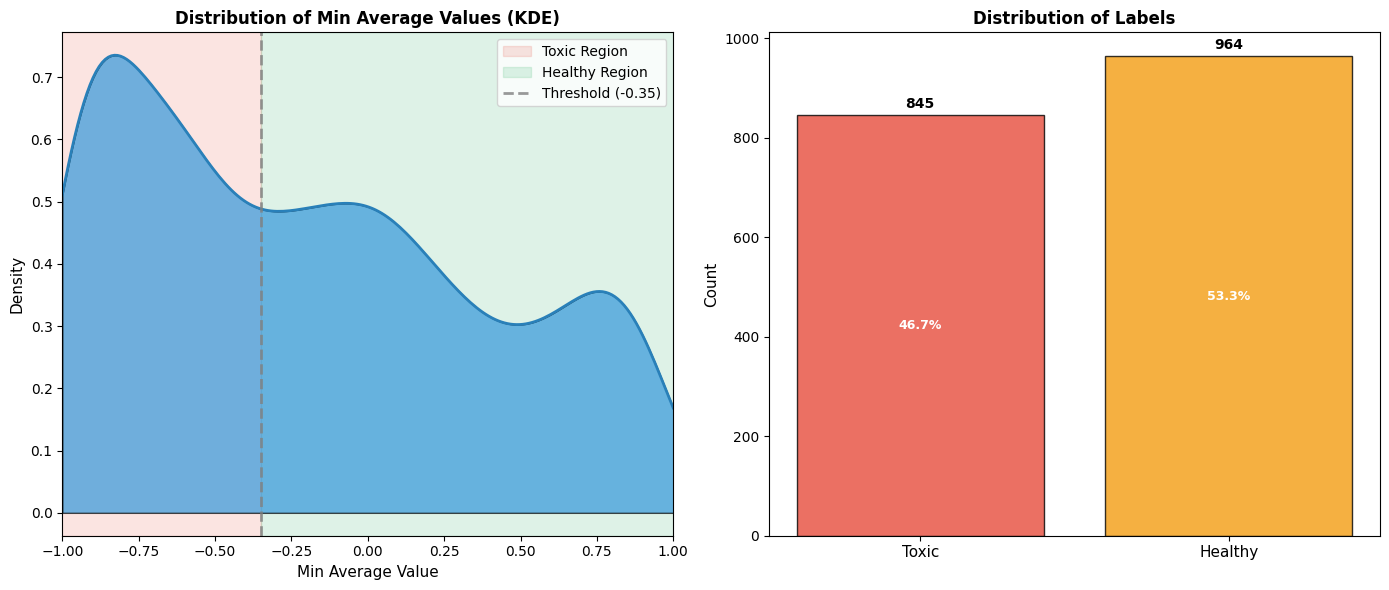

In [14]:
plot_value_distribution(df)

In [15]:
def plot_messages_length_distribution(df):
    lengths = df['messages'].apply(len)
    max_msgs = lengths.max()
    lengths.hist(
        bins=range(max_msgs + 2),  # +2 so last bin includes max
        color="skyblue",
        edgecolor="black",
        label='Messages Lengths',
        align='left'
    )
    plt.xlabel('Number of Messages')
    plt.ylabel('Frequency')
    plt.title('Messages Length Distribution')
    plt.legend()
    # plt.savefig(os.path.join(OUT_DIR, "messages_length_distribution.png"))
    plt.yscale('log')
    plt.xticks(range(max_msgs + 1))
    plt.grid(False)
    plt.show()

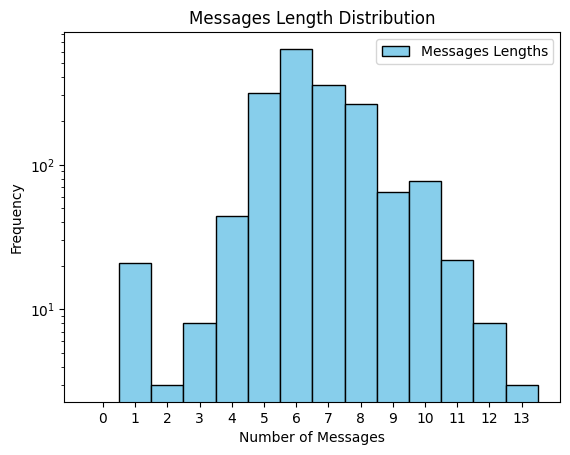

In [16]:
plot_messages_length_distribution(df)

# Saving

In [17]:
# save to csv
df = df[['couple_ids', 'messages', 'labels']]
print(df.info())
# df.to_parquet(os.path.join(".", "out", "datasets", f"cipv-chats-{TASK}-{DATASET_TYPE}.parquet"), index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1809 entries, 0 to 2078
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   couple_ids  1809 non-null   object
 1   messages    1809 non-null   object
 2   labels      1809 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 49.5+ KB
None
